# ***Generate Query,Key And Values Vector For Each Word***
## ***👉 Think of this as: for each word, the model creates 3 vectors (Q, K, V).***

In [1]:
import numpy as np
L, d_k, d_v = 4, 8, 8 #--> length of word = 4 , dim of query key and value vector = 8
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)

In [2]:
print("Query Vector: \n",q[0])
print("Key Vector: \n",k[0])
print("Value Vector: \n",v[0])

Query Vector: 
 [ 1.23342342  0.37384648 -0.83759329  0.9508095   1.57232559 -0.12486714
  0.31667598 -1.54425556]
Key Vector: 
 [-0.53175197 -0.207371    0.32410283 -0.1982549  -0.55739688  0.52738841
  2.36916122  1.34216401]
Value Vector: 
 [ 0.85477811 -0.88271282 -0.19521454  0.38517066 -0.24088169  0.27566607
  0.41157041 -0.90048944]


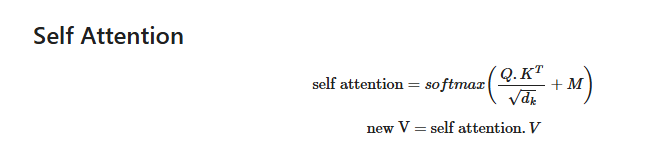

In [3]:
"""
Multiply Q with K transpose → this gives us a similarity score between words.
Shape = (L, L) → here (4×4).
Each number says: How much should this word pay attention to another word?
👉 Example: score[0,1] = how much word 0 should attend to word 1
"""
np.matmul(q, k.T)

array([[-3.45801987, -2.53901238,  4.05237147, -2.7434139 ],
       [ 1.46920046,  2.22617554, -1.64970736,  2.24059765],
       [-4.3275494 , -0.24211001,  2.16855253,  0.93212963],
       [-5.82265157,  0.7990716 ,  1.79126061, -4.88007151]])

# ***Why we need sqrt(d_k) in denominator***

In [4]:
q.var(), k.var(), np.matmul(q, k.T).var()

(np.float64(1.0629677650572704),
 np.float64(0.6867131309933279),
 np.float64(8.556439818497527))

In [5]:
'''
If we don’t divide, dot products get too large when d_k is big.
Large values make softmax outputs very sharp (like 0 or 1), which makes learning unstable.
Dividing by √d_k keeps values in a reasonable range → variance is smaller and stable.
👉 It’s just a normalization trick
'''

import math
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(np.float64(1.0629677650572704),
 np.float64(0.6867131309933279),
 np.float64(1.0695549773121908))

In [6]:
scaled

array([[-1.22259465, -0.89767644,  1.43272967, -0.96994329],
       [ 0.5194408 ,  0.78707191, -0.58325963,  0.79217089],
       [-1.53001976, -0.08559881,  0.7666991 ,  0.32955759],
       [-2.0586182 ,  0.28251447,  0.63330626, -1.72536583]])

# ***Masking***

1. This is to ensure words don't get context from words generated in the
future.
2. Not required in the encoders, but required int he decoders



In [7]:
"""
Makes a lower triangular matrix.
This prevents looking into the future words (important for text generation).
Encoder: No mask needed (all words can see each other).
Decoder: Mask needed (word at position i can only see positions ≤ i).
👉 Example: when predicting the 3rd word, we don’t want to peek at the 4th word.
"""

mask = np.tril(np.ones( (L, L) ))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [8]:
mask[mask == 0] = -np.inf
mask[mask == 1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [9]:
scaled + mask

array([[-1.22259465,        -inf,        -inf,        -inf],
       [ 0.5194408 ,  0.78707191,        -inf,        -inf],
       [-1.53001976, -0.08559881,  0.7666991 ,        -inf],
       [-2.0586182 ,  0.28251447,  0.63330626, -1.72536583]])

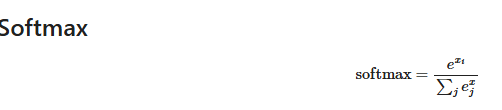

In [10]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [11]:
"""
Softmax takes each row of scores and converts them into probabilities (between 0 and 1).
Row sums = 1.
Now we know how much attention each word should give to others.
👉 Example:
If row = [0.7, 0.2, 0.1], word focuses 70% on word1, 20% on word2, 10% on word3.
"""

attention = softmax(scaled + mask)

In [12]:
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.43348875, 0.56651125, 0.        , 0.        ],
       [0.06587222, 0.27925847, 0.65486931, 0.        ],
       [0.03629954, 0.37726123, 0.53578323, 0.05065599]])

In [13]:
"""
Each word gets a new representation.
It’s a weighted sum of all value vectors (V), weighted by the attention probabilities.
This means the word’s new meaning is influenced by the words it attends to.
👉 Example: If word 1 attends mostly to word 3, its new vector is mostly based on V3.
"""

new_v = np.matmul(attention, v)
new_v

array([[ 0.85477811, -0.88271282, -0.19521454,  0.38517066, -0.24088169,
         0.27566607,  0.41157041, -0.90048944],
       [ 0.03479235, -0.15705441,  0.49561016,  0.39553868, -0.06899277,
        -0.21183451, -0.06671169, -0.43974098],
       [-1.32005932, -1.35254265,  1.34484145,  1.47153947,  0.10034323,
         0.56416415, -0.96562535,  0.20164793],
       [-1.20946269, -1.10164482,  1.35285383,  1.26451592,  0.14014604,
         0.36579434, -0.80409476,  0.2111656 ]])

In [14]:
v

array([[ 0.85477811, -0.88271282, -0.19521454,  0.38517066, -0.24088169,
         0.27566607,  0.41157041, -0.90048944],
       [-0.59265255,  0.39821215,  1.02422231,  0.40347218,  0.06253491,
        -0.58486507, -0.43268837, -0.08718087],
       [-1.84901352, -2.14638324,  1.636476  ,  2.03627561,  0.15078924,
         1.0831687 , -1.33141759,  0.4356765 ],
       [-0.51791451, -1.37864457,  1.90982842,  0.14445804,  0.87862448,
        -0.07716592,  1.13615744,  0.8550766 ]])

# ***Function***

In [15]:
"""
This is the core of self-attention:
Compute similarity (QKᵀ / √d_k).
Apply mask (if needed).
Softmax → attention weights.
Multiply with V → new values.
"""

def scaled_dot_product_attention(q, k, v, mask=None):
  d_k = q.shape[-1]
  scaled = np.matmul(q, k.T) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled + mask
  attention = softmax(scaled)
  out = np.matmul(attention, v)
  return out, attention


In [16]:
values, attention = scaled_dot_product_attention(q, k, v, mask=mask)
print("Q\n", q[0])
print("K\n", k[0])
print("V\n", v[0])


"""
These are the new representations of words, after mixing in context from others.
They are what gets passed to the next Transformer layer.
"""
print("New V\n", values)


"""
Each row tells how much a word attends to others.
Row 0 attends only to itself ([1,0,0,0]) because of masking.
Row 2 attends mostly to word0, a bit to word1 and word2.
Row 3 attends mostly to word2.
"""
print("Attention\n", attention)

Q
 [ 1.23342342  0.37384648 -0.83759329  0.9508095   1.57232559 -0.12486714
  0.31667598 -1.54425556]
K
 [-0.53175197 -0.207371    0.32410283 -0.1982549  -0.55739688  0.52738841
  2.36916122  1.34216401]
V
 [ 0.85477811 -0.88271282 -0.19521454  0.38517066 -0.24088169  0.27566607
  0.41157041 -0.90048944]
New V
 [[ 0.85477811 -0.88271282 -0.19521454  0.38517066 -0.24088169  0.27566607
   0.41157041 -0.90048944]
 [ 0.03479235 -0.15705441  0.49561016  0.39553868 -0.06899277 -0.21183451
  -0.06671169 -0.43974098]
 [-1.32005932 -1.35254265  1.34484145  1.47153947  0.10034323  0.56416415
  -0.96562535  0.20164793]
 [-1.20946269 -1.10164482  1.35285383  1.26451592  0.14014604  0.36579434
  -0.80409476  0.2111656 ]]
Attention
 [[1.         0.         0.         0.        ]
 [0.43348875 0.56651125 0.         0.        ]
 [0.06587222 0.27925847 0.65486931 0.        ]
 [0.03629954 0.37726123 0.53578323 0.05065599]]


# ✅ In short:

### QKᵀ → similarity scores
### ÷√d_k → normalize
### mask → block future words
### softmax → attention probabilities
### attention × V → new word embeddings